Topology of the Brain Networks Analysis 

In [3]:
!pip3 install networkx
!pip3 install community
!pip3 install gudhi
!pip3 install seaborn
!pip install python-louvain
!pip install h5py

In [1]:

import numpy as np  
import networkx as nx  
import community  
import gudhi 
import scipy.io  
from sklearn import preprocessing
import itertools
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy.io import loadmat
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import pandas as pd

import jpype as jp
import jpype.imports
from jpype.types import *
import community.community_louvain as community_louvain
# import resting_state_synergy_redundancy 
import h5py
import brainconn
from brainconn.brainconn.distance import efficiency_wei
from scipy.stats import spearmanr


/rds/general/user/ab5621/home/venv/lib/python3.6/site-packages/nilearn/__init__.py:69: FutureWarning: Python 3.6 support is deprecated and will be removed in release 0.10 of Nilearn. Consider switching to Python 3.8 or 3.9.
  _python_deprecation_warnings()
Failed to import duecredit due to No module named 'duecredit'


In [6]:
def functional_connectivity():
    '''
    Computes functional connectivity matrix

    Returns
    -------
    average_fc : np.ndarray
        The average functional connectivity across all subjects
    '''
    #Loading the BOLD fMRI movie data for each subject
    average_fc = np.zeros(shape=(232,232))
    for i in range(1, 87):
        #Loading data for the i'th subject
        data=loadmat(f'/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/extended_schaefer_200/sub-{i}/full_ts.mat')
        data = data['data']
        #Computing functional connectivity
        functional_connectivity = np.corrcoef(data)
        average_fc += functional_connectivity
    average_fc = average_fc / 86
    average_fc = abs(average_fc) #we absolutise the matrix

    return average_fc

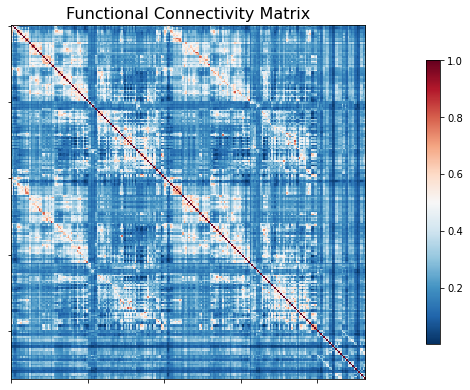

In [8]:
average_fc = functional_connectivity()
#Plotting the averaged functional connectivity matrix over all subjects
plotting.plot_matrix(average_fc)
plt.title('Functional Connectivity Matrix', fontsize=16)
plt.show()

In [23]:
#Getting modularity for each synergy matrix 
#For each subject, we get the synergy matrix, and then compute modularity on the synergy matrix
#We then do a violin plot with the modularities for each subject for rest vs non-rest data

def get_modularity(information_measure):
    '''
    Computes the modularity of the whole-brain synergy and redundancy network for resting and movie state

    Parameters
    ----------
    information_measure : str
        type of information atom (synergy, redundancy, unique)

    Returns
    -------
    modularity_movie_list : list of floats
        A list of modularity values computed for the movie state for each subject
    modularity_rest_list : list of floats
        A list of modularity values computed for the resting state for each subjects

    '''
    modularity_rest_list =list()
    modularity_movie_list =list()

    for i in range(1, 87):
        #Loading movie data for each subject

        movie_info = pd.read_csv(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/{information_measure}_corr_{i}.csv',header=None)
        movie_info = np.array(movie_info)

        # #Loading rest data for each subject
        rest_info = pd.read_csv(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/resting_{information_measure}_corr_{i}.csv', header=None)
        rest_info = np.array(rest_info)

        movie_info = abs(movie_info)
        rest_info = abs(rest_info)
        #Creating a graph
        G_movie = nx.from_numpy_matrix(movie_info)
        G_rest = nx.from_numpy_matrix(rest_info)
        
        # Removing self-loops
        G_movie.remove_edges_from(list(nx.selfloop_edges(G_movie)))
        G_rest.remove_edges_from(list(nx.selfloop_edges(G_rest)))

        #Computing modularity for each subject
        #movie state
        partition_movie = community_louvain.best_partition(G_movie) #Computing best partition
        modularity_movie = community_louvain.modularity(partition_movie, G_movie)
        #rest state
        partition_rest = community_louvain.best_partition(G_rest) #Computing best partition
        modularity_rest = community_louvain.modularity(partition_rest, G_rest)

        modularity_movie_list.append(modularity_movie)
        modularity_rest_list.append(modularity_rest)

    return modularity_movie_list, modularity_rest_list

In [24]:
def get_global_efficiency(information_measure):
    '''
    Computes the global efficiency of the whole-brain synergy and redundancy network for resting and movie

    Parameters
    ----------
    information_measure : str
        type of information atom (synergy, redundancy, unique)


    Returns
    -------
    efficiency_movie_list : list of floats
        A list of global efficiency values computed for the movie state for each subject
    efficiency_rest_list : list of floats
        A list of global efficiency values computed for the resting state for each subject

    '''
    efficiency_rest_list = []
    efficiency_movie_list = []

    for i in range(1, 87):
        # Loading movie data for each subject
        movie_info = pd.read_csv(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/{information_measure}_corr_{i}.csv', header=None)
        movie_info = np.array(movie_info)

        # Loading rest data for each subject

        rest_info = pd.read_csv(f"/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/resting_{information_measure}_corr_{i}.csv", header=None)
        rest_info = np.array(rest_info)

        # Taking absolute values of the connectivity matrices
        movie_info = np.abs(movie_info)
        rest_info = np.abs(rest_info)

        # Computing global efficiency for each subject using brainconn
        efficiency_movie = efficiency_wei(movie_info, local = False)
        efficiency_rest = efficiency_wei(rest_info, local = False)

        # Appending them to the lists of efficiency for each subject
        efficiency_movie_list.append(efficiency_movie)
        efficiency_rest_list.append(efficiency_rest)
        
    return efficiency_movie_list, efficiency_rest_list

In [25]:
#Global efficient for movie and resting states for synergy and redundancy
efficiency_movie_syn, efficiency_rest_syn = get_global_efficiency('synergy')
efficiency_movie_red, efficiency_rest_red = get_global_efficiency('redundancy')


In [26]:
#Modularity for movie and rest states for synergy and redundancy
modularity_movie_syn, modularity_rest_syn = get_modularity('synergy')
modularity_movie_red, modularity_rest_red = get_modularity('redundancy')

In [27]:
#Global efficiency and modularity for unique
efficiency_movie_uni, efficiency_rest_uni = get_global_efficiency('unique')
modularity_movie_uni, modularity_rest_uni = get_modularity('unique')

In [62]:
def plot_violins(data_list1, data_list2, title, categories, ylabel):
    '''
    Plots violin plots for efficiency and modularity
    '''
    # Getting our color map
    colors = ['#1f77b4', '#ff7f0e']
    plt.figure(figsize=(12, 6))
    
    # Plotting each violin separately
    for idx, (d, color) in enumerate(zip([data_list1, data_list2], colors)):
        violin_parts = plt.violinplot([d], positions=[idx + 1], showmeans=True, showmedians=True)
        for partname in ('cbars', 'cmins', 'cmaxes'):
            violin_parts[partname].set_edgecolor(color)
        for part in violin_parts['bodies']:
            part.set_facecolor(color)
            part.set_edgecolor(color)
    

    plt.xticks(range(1, len(categories) + 1), categories, fontsize=14)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(title, fontsize=20)
    
    plt.show()


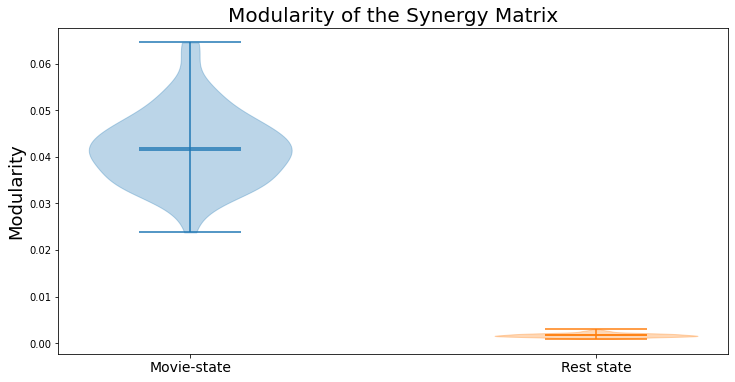

In [70]:
plot_violins(data_list1 = modularity_movie_syn, data_list2=modularity_rest_syn, categories=['Movie-state', 'Rest state'], title = 'Modularity of the Synergy Matrix', ylabel = 'Modularity')

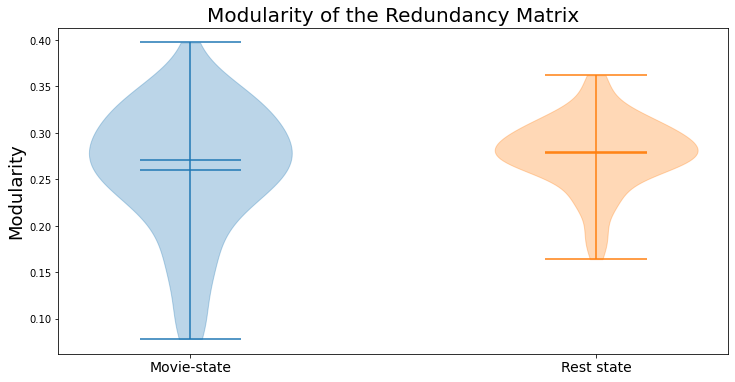

In [71]:
plot_violins(data_list1 = modularity_movie_red, data_list2=modularity_rest_red, categories=['Movie-state','Rest state'], title = 'Modularity of the Redundancy Matrix', ylabel = 'Modularity')

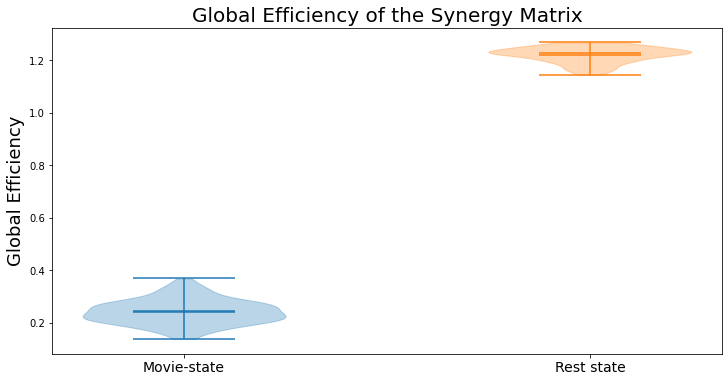

In [72]:
plot_violins(data_list1 = efficiency_movie_syn, data_list2=efficiency_rest_syn, categories=['Movie-state', 'Rest state'], title = 'Global Efficiency of the Synergy Matrix', ylabel = 'Global Efficiency')

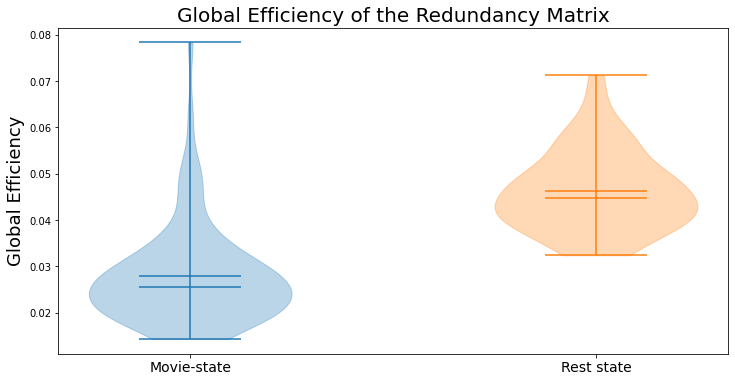

In [73]:
plot_violins(data_list1 = efficiency_movie_red, data_list2=efficiency_rest_red, categories=['Movie-state', 'Rest state'], title = 'Global Efficiency of the Redundancy Matrix', ylabel = 'Global Efficiency')

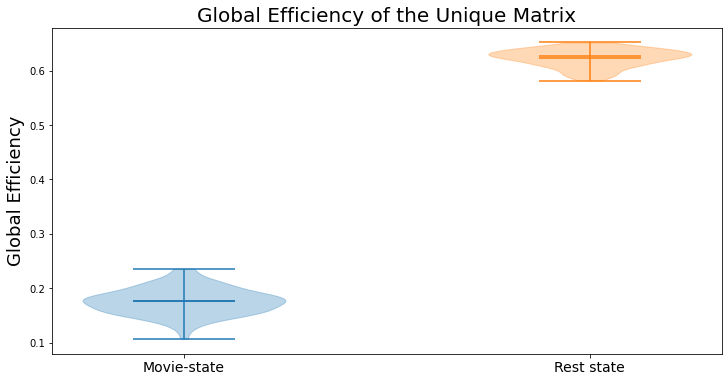

In [74]:
plot_violins(data_list1 = efficiency_movie_uni, data_list2=efficiency_rest_uni, categories=['Movie-state', 'Rest state'], title = 'Global Efficiency of the Unique Matrix', ylabel = 'Global Efficiency')

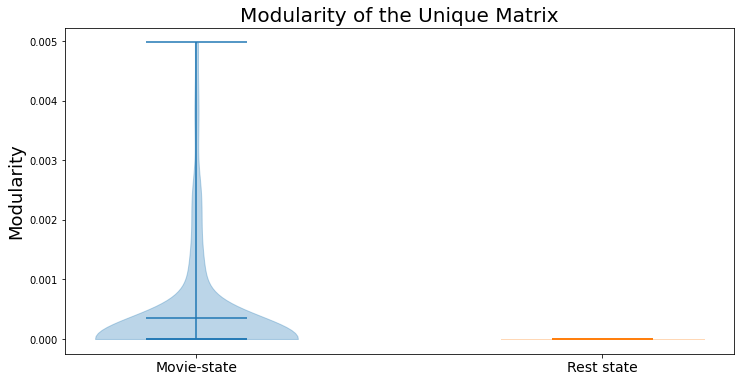

In [75]:
plot_violins(data_list1 = modularity_movie_uni, data_list2=modularity_rest_uni, categories=['Movie-state','Rest state'], title = 'Modularity of the Unique Matrix', ylabel = 'Modularity')

In [36]:
def open_resting_state_file(resting_state_file_path = '/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/BOLD_timeseries_HCP.mat'):
    '''
    Opens the resting-state data

    Returns
    ----------
    combined_resting_state_data :np.ndarray
                                matrix of BOLD signals for resting state
    '''
    # Open the HDF5 file
    with h5py.File(resting_state_file_path, 'r') as file:
        # acessing the dataset containing object references
        resting_state_dataset = file['BOLD_timeseries_HCP']

        # reading the dataset containing references into an array
        resting_data = resting_state_dataset[()]

        # Initializing a list to store the data arrays
        data_arrays = []

        for ref_array in resting_data:
            for i in range(len(ref_array)):
                ref = ref_array[i]

                # Dereference the HDF5 object reference
                dereferenced_data = file[ref]

                # converting the dataset to a numpy array and appending it to the list
                data_arrays.append(dereferenced_data[:])

        combined_resting_state_data = np.stack(data_arrays, axis=0)
        combined_resting_state_data = combined_resting_state_data.transpose(0, 2, 1)
        
    return combined_resting_state_data

In [37]:

def fc_topology():
    '''
    Computes modularity and global efficiency for both rest and movie for functional connectivity matrix

    Parameters
    ----------
    information_measure : str
        type of information atom (synergy, redundancy, unique)

    Returns
    -------
    efficiency_movie_list : list of floats
        A list of global efficiency values computed for movie state for each subject
    efficiency_rest_list : list of float
        A list of global efficiency values computed for resting state for each subject

    '''
    movie_mod = []
    movie_eff = []
    rest_mod = []
    rest_eff = []

    for i in range(1, 87):
        # Getting the functional connectivity matrix from the movie fMRI
        data_movie = loadmat(f'/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/extended_schaefer_200/sub-{i}/full_ts.mat')
        data_movie = data_movie['data']
        fc_movie = np.corrcoef(data_movie)
        fc_movie = abs(fc_movie)

        # Getting the functional connectivity matrix from the rest fMRI
        rest_data = open_resting_state_file(resting_state_file_path = '/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/BOLD_timeseries_HCP.mat')
        rest_data = rest_data[i]
        fc_rest = np.corrcoef(rest_data)
        fc_rest = abs(fc_rest)

        # Creating a graph
        G_movie = nx.from_numpy_matrix(fc_movie)
        G_rest = nx.from_numpy_matrix(fc_rest)
        

        # Computing global efficiency for each subject using brainconn
        efficiency_movie = efficiency_wei(fc_movie)
        efficiency_rest = efficiency_wei(fc_rest)

        # Appending them to the lists of efficiency for each subject
        movie_eff.append(efficiency_movie)
        rest_eff.append(efficiency_rest)
        
        # Computing modularity for each subject
        partition_movie = community_louvain.best_partition(G_movie)  # Computing best partition
        modularity_movie = community_louvain.modularity(partition_movie, G_movie)
        
        partition_rest = community_louvain.best_partition(G_rest)  # Computing best partition
        modularity_rest = community_louvain.modularity(partition_rest, G_rest)

        movie_mod.append(modularity_movie)
        rest_mod.append(modularity_rest)

    return movie_mod, rest_mod, movie_eff, rest_eff


In [38]:
movie_mod, rest_mod, movie_eff, rest_eff = fc_topology()

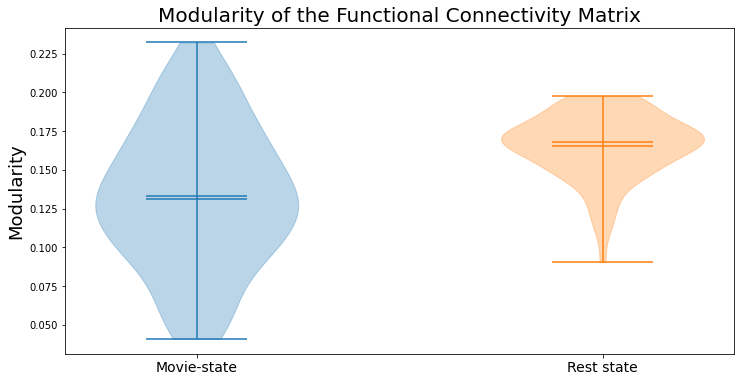

In [64]:
plot_violins(data_list1 = movie_mod, data_list2=rest_mod, categories=[ 'Movie-state', 'Rest state'], title = 'Modularity of the Functional Connectivity Matrix', ylabel = 'Modularity')

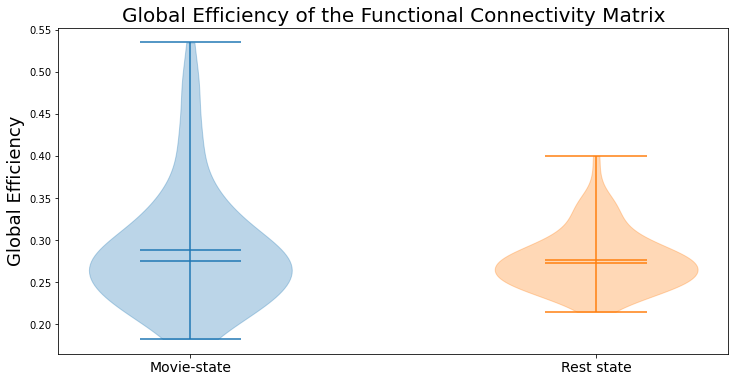

In [65]:
plot_violins(data_list1 = movie_eff, data_list2=rest_eff, categories=[ 'Movie-state', 'Rest state'], title = 'Global Efficiency of the Functional Connectivity Matrix', ylabel = 'Global Efficiency')

Structural Connectivity Analysis

In [2]:
#Loading the diffusion tensor imaging data
rest_consensus = loadmat('/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/DTI_fiber_consensus_HCP.mat')
rest_consensus = rest_consensus['connectivity']

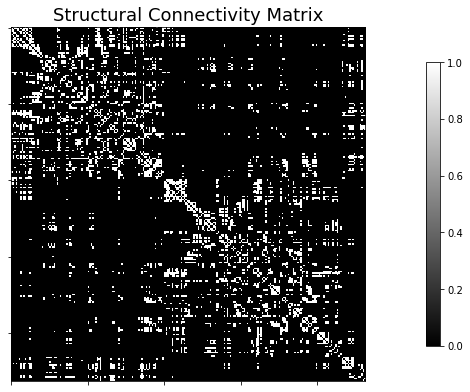

In [7]:
#plotting the structural connectivity matrix
plotting.plot_matrix(rest_consensus, cmap = 'gray', vmin = 0, vmax = 1)
plt.title('Structural Connectivity Matrix', fontsize=18)
plt.show()

In [44]:

def compute_gmi(matrix1, matrix2):
    '''
    Computes the mutual information between two matrices

    Parameters
    ----------
    matrix1 : np.ndarray
    matrix2 : np.ndarray

    Returns
    -------
    mutual_info : float
        mutual information value between two matrices
    '''
    jarLocation = '/rds/general/user/ab5621/home/Masters-Dissertation/Helper Files/infodynamics-dist-1.6.1/infodynamics.jar'
    if not jp.isJVMStarted():
        jp.startJVM(jp.getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

    flat_matrix1 = matrix1.flatten()
    flat_matrix2 = matrix2.flatten()


    java_matrix1 = JArray(JDouble, 1)(flat_matrix1.tolist())
    java_matrix2 = JArray(JDouble, 1)(flat_matrix2.tolist())
    
    miCalcClass = jpype.JClass('infodynamics.measures.continuous.gaussian.MutualInfoCalculatorMultiVariateGaussian')
    miCalc = miCalcClass()
    miCalc.setObservations(java_matrix1, java_matrix2)
    mutual_info = miCalc.computeAverageLocalOfObservations()
    
    return mutual_info



In [45]:
def mutual_info_corr(measure, structural_connectivity_matrix):
    '''
    Computes mutual information between synergy/redundancy and the structural connectivity matrix

    Parameters
    ----------
    measure : str
        type of information atom (synergy, redundancy, unique)
    structural_connectivity_matrix : np.ndarray
        structural connectivity matrix 

    Returns
    -------
    movie_mi_list : list of float
        A list of mutual information values between the information atom matrix and the structural connectivity matrix for the movie state
    rest_mi_list : list of float
        A list of mutual information values between the information atom matrix and the structural connectivity matrix for the resting state
    '''
    movie_mi_list = []
    rest_mi_list = []
    rest_data = open_resting_state_file()
    for i in range(1, 87):
        #Loading the synergy/redundancy matrices for each subject for movie state
        measure_movie_data = pd.read_csv(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/{measure}_corr_{i}.csv', header=None)
        measure_movie_data = np.array(measure_movie_data)

        #Loading the synergy/redundancy matrices for each subject for rest state
        rest_data = pd.read_csv(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/resting_{measure}_corr_{i}.csv', header=None)
        rest_data = np.array(rest_data)

        #Computing the mutual information between each  matrix and the structural connectivity matrix and then adding it to the list
        measure_mi_movie = compute_gmi(measure_movie_data, structural_connectivity_matrix)
        measure_mi_rest = compute_gmi(rest_data, structural_connectivity_matrix)

        movie_mi_list.append(measure_mi_movie)
        rest_mi_list.append(measure_mi_rest)
    return movie_mi_list, rest_mi_list


    

In [46]:
movie_mi_list_syn, rest_mi_list_syn = mutual_info_corr(measure='synergy', structural_connectivity_matrix=rest_consensus)
movie_mi_list_red, rest_mi_list_red = mutual_info_corr(measure='redundancy', structural_connectivity_matrix=rest_consensus)


In [47]:
movie_mi_list_uni, rest_mi_list_uni = mutual_info_corr(measure='unique', structural_connectivity_matrix=rest_consensus)


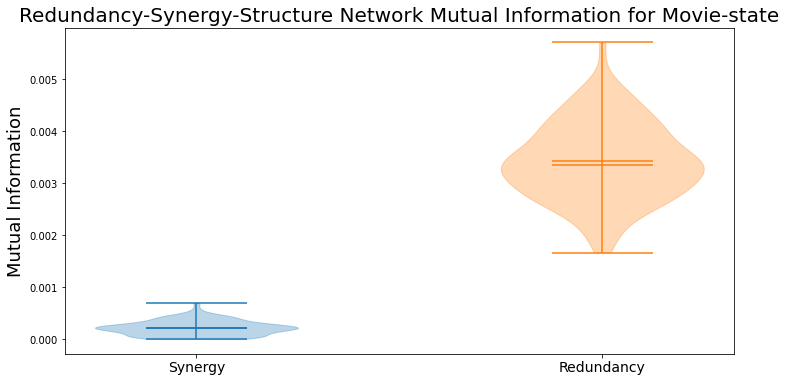

In [79]:
plot_violins(data_list1 = movie_mi_list_syn, data_list2=movie_mi_list_red, categories=[ 'Synergy', 'Redundancy'], title = 'Redundancy-Synergy-Structure Network Mutual Information for Movie-state', ylabel = 'Mutual Information')

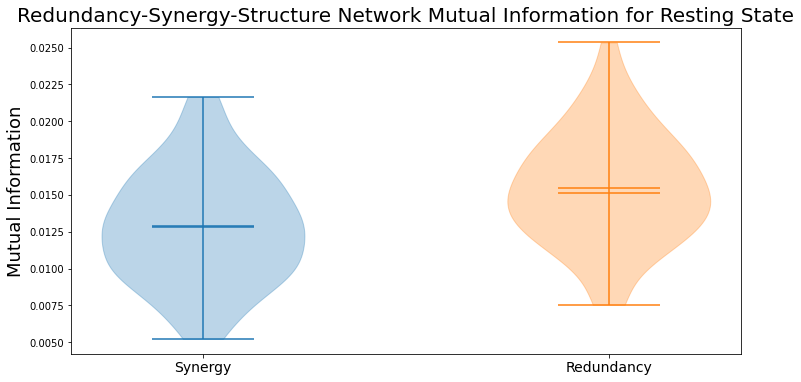

In [78]:
plot_violins(data_list1 = rest_mi_list_syn, data_list2=rest_mi_list_red, categories=[ 'Synergy', 'Redundancy'], title = 'Redundancy-Synergy-Structure Network Mutual Information for Resting State', ylabel = 'Mutual Information')

In [50]:
def spearman_corr_sc(measure, structural_connectivity_matrix):
    '''
    Computes Spearman's correlation between synergy/redundancy and the structural connectivity matrix
    '''
    movie_corr_list = []
    rest_corr_list = []

    for i in range(1, 87):
        # Loading the synergy/redundancy matrices for each subject for movie state
        measure_movie_data = pd.read_csv(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/{measure}_corr_{i}.csv', header=None)
        measure_movie_data = np.array(measure_movie_data)

        # Loading the synergy/redundancy matrices for each subject for rest state
        rest_data = pd.read_csv(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/resting_{measure}_corr_{i}.csv', header=None)
        rest_data = np.array(rest_data)

        # Computing the Spearman's rho between each matrix and the structural connectivity matrix and then adding it to the list
        measure_corr_movie = spearmanr(measure_movie_data, structural_connectivity_matrix, axis=0)
        measure_corr_rest = spearmanr(rest_data, structural_connectivity_matrix, axis=0)

        movie_corr_list.append(measure_corr_movie)
        rest_corr_list.append(measure_corr_rest)

    return movie_corr_list, rest_corr_list

In [51]:


def spearman_corr(matrix1, matrix2, axis=None):
    """
    Computes the Spearman's rho correlation coefficient between two matrices

    """
    if axis is None:
        matrix1_flat = matrix1.ravel()
        matrix2_flat = matrix2.ravel()

        rho, _ = spearmanr(matrix1_flat, matrix2_flat)
    else:
        rho, _ = spearmanr(matrix1, matrix2, axis=axis)
    
    return rho

def spearman_corr_list(measure, structural_connectivity_matrix, axis=None):
    movie_corr_list = []
    rest_corr_list = []

    for i in range(1, 87):
        # Loading the synergy/redundancy matrices for each subject for movie state
        measure_movie_data = pd.read_csv(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/{measure}_corr_{i}.csv', header=None)
        measure_movie_data = np.array(measure_movie_data)

        # Loading the synergy/redundancy matrices for each subject for rest state
        rest_data = pd.read_csv(f'/rds/general/user/ab5621/home/Masters-Dissertation/Results/Synergy_Redundancy_data/resting_{measure}_corr_{i}.csv', header=None)
        rest_data = np.array(rest_data)

        # Computing the Spearman's rho between each matrix and the structural connectivity matrix and then adding it to the list
        measure_corr_movie = spearman_corr(measure_movie_data, structural_connectivity_matrix, axis=axis)
        measure_corr_rest = spearman_corr(rest_data, structural_connectivity_matrix, axis=axis)

        movie_corr_list.append(measure_corr_movie)
        rest_corr_list.append(measure_corr_rest)

    return movie_corr_list, rest_corr_list




In [52]:
movie_corr_syn, rest_corr_syn = spearman_corr_list(measure='synergy', structural_connectivity_matrix=rest_consensus)

In [53]:
movie_corr_red, rest_corr_red = spearman_corr_list(measure='redundancy', structural_connectivity_matrix=rest_consensus)

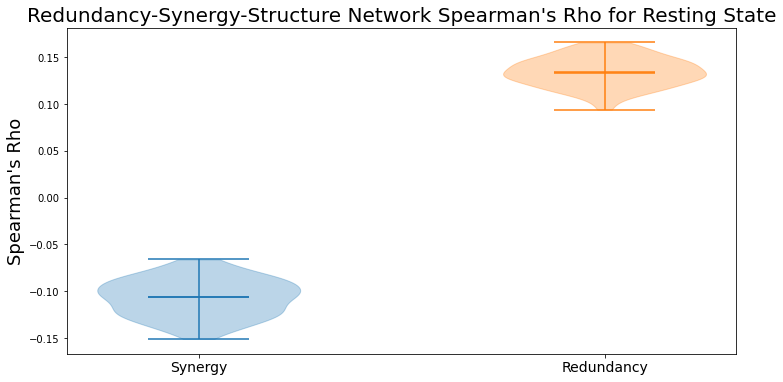

In [69]:
plot_violins(data_list1 = rest_corr_syn, data_list2=rest_corr_red, categories=[ 'Synergy', 'Redundancy'], title = "Redundancy-Synergy-Structure Network Spearman's Rho for Resting State", ylabel = "Spearman's Rho")

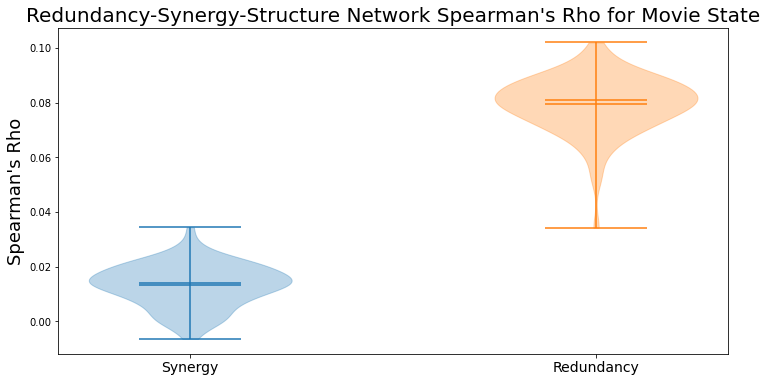

In [80]:
plot_violins(data_list1 = movie_corr_syn, data_list2=movie_corr_red, categories=[ 'Synergy', 'Redundancy'], title = "Redundancy-Synergy-Structure Network Spearman's Rho for Movie State", ylabel = "Spearman's Rho")